In [1]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from tqdm import tqdm
import sqlite3 as sl
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
config = load_config_and_check("../config/qmt_v01.yaml")

## Inspect AST Manually

In [34]:
import ast
import astpretty

In [35]:
def show_tree(code: str):
    tree = ast.parse(code)
    astpretty.pprint(tree)

In [5]:
show_tree("""
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)
""")

Module(
    body=[
        ImportFrom(
            lineno=2,
            col_offset=0,
            end_lineno=2,
            end_col_offset=28,
            module='qiskit',
            names=[alias(name='transpile', asname=None)],
            level=0,
        ),
        Assign(
            lineno=3,
            col_offset=0,
            end_lineno=3,
            end_col_offset=58,
            targets=[Name(lineno=3, col_offset=0, end_lineno=3, end_col_offset=2, id='qc', ctx=Store())],
            value=Call(
                lineno=3,
                col_offset=5,
                end_lineno=3,
                end_col_offset=58,
                func=Name(lineno=3, col_offset=5, end_lineno=3, end_col_offset=14, id='transpile', ctx=Load()),
                args=[Name(lineno=3, col_offset=15, end_lineno=3, end_col_offset=17, id='qc', ctx=Load())],
                keywords=[
                    keyword(
                        arg='basis_gates',
                        value=Constant(lineno=

In [6]:
show_tree("""
from qiskit import transpile
qc = transpile(qc, basis_gates=['rx', 'ry', 'rz', 'h', 'cx'], optimization_level=0)
""")

Module(
    body=[
        ImportFrom(
            lineno=2,
            col_offset=0,
            end_lineno=2,
            end_col_offset=28,
            module='qiskit',
            names=[alias(name='transpile', asname=None)],
            level=0,
        ),
        Assign(
            lineno=3,
            col_offset=0,
            end_lineno=3,
            end_col_offset=83,
            targets=[Name(lineno=3, col_offset=0, end_lineno=3, end_col_offset=2, id='qc', ctx=Store())],
            value=Call(
                lineno=3,
                col_offset=5,
                end_lineno=3,
                end_col_offset=83,
                func=Name(lineno=3, col_offset=5, end_lineno=3, end_col_offset=14, id='transpile', ctx=Load()),
                args=[Name(lineno=3, col_offset=15, end_lineno=3, end_col_offset=17, id='qc', ctx=Load())],
                keywords=[
                    keyword(
                        arg='basis_gates',
                        value=List(
          

# Matamorphic Relationships

In [44]:
from qmt import get_mr_function_and_kwargs

In [45]:
from metamorph import *

## Change Target Basis

In [154]:
config["metamorphic_strategies"]

[{'name': 'change_backend',
  'function': 'mr_change_backend',
  'kwargs': {'available_backends': ['aer_simulator',
    'aer_simulator_statevector',
    'aer_simulator_statevector_gpu',
    'aer_simulator_density_matrix_gpu',
    'aer_simulator_stabilizer',
    'aer_simulator_matrix_product_state']}},
 {'name': 'change_basis',
  'function': 'mr_change_basis',
  'kwargs': {'universal_gate_sets': [{'gates': ['rx', 'ry', 'rz', 'p', 'cx']},
    {'gates': ['cx', 'h', 's', 't']},
    {'gates': ['ccx', 'h']}]}},
 {'name': 'change_opt_level',
  'function': 'mr_change_opt_level',
  'kwargs': {'levels': [0, 1, 2, 3]}},
 {'name': 'change_qubit_order',
  'function': 'mr_change_qubit_order',
  'kwargs': {'scramble_percentage': 0.5}}]

In [10]:
morph, kwargs = get_mr_function_and_kwargs(config, metamorphic_strategy="change_basis")
print(morph("""
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)
""", **kwargs)[0])

Follow: gateset replaced with:  ['cx', 'h', 's', 't']
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=['cx', 'h', 's', 't'], optimization_level=0)



## Change Optimization Level

In [162]:
morph, kwargs = get_mr_function_and_kwargs(config, metamorphic_strategy="change_opt_level")

np.random.seed(42)
print(morph("""
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=1)
""", **kwargs)[0])

Follow: optimization level changed: 1 -> 3
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=3, optimization_level=1)



## Change Qubit Order

In [12]:
show_tree("""
qr_qr = QuantumRegister(16, name='qr_qr')
cr_qr = ClassicalRegister(16, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(C3XGate(3.907524998275438), qargs=[qr_qr[11], qr_qr[8], qr_qr[7], qr_qr[0]], cargs=[])
""")

Module(
    body=[
        Assign(
            lineno=2,
            col_offset=0,
            end_lineno=2,
            end_col_offset=41,
            targets=[Name(lineno=2, col_offset=0, end_lineno=2, end_col_offset=5, id='qr_qr', ctx=Store())],
            value=Call(
                lineno=2,
                col_offset=8,
                end_lineno=2,
                end_col_offset=41,
                func=Name(lineno=2, col_offset=8, end_lineno=2, end_col_offset=23, id='QuantumRegister', ctx=Load()),
                args=[Constant(lineno=2, col_offset=24, end_lineno=2, end_col_offset=26, value=16, kind=None)],
                keywords=[
                    keyword(
                        arg='name',
                        value=Constant(lineno=2, col_offset=33, end_lineno=2, end_col_offset=40, value='qr_qr', kind=None),
                    ),
                ],
            ),
            type_comment=None,
        ),
        Assign(
            lineno=3,
            col_offset=

In [17]:
morph, kwargs = get_mr_function_and_kwargs(config, metamorphic_strategy="change_qubit_order")
print(morph("""
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(16, name='qr_qr')
cr_qr = ClassicalRegister(16, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(C3XGate(3.907524998275438), qargs=[qr_qr[11], qr_qr[8], qr_qr[7], qr_qr[0]], cargs=[])
qc.append(RC3XGate(), qargs=[qr_qr[8], qr_qr[15], qr_qr[5], qr_qr[14]], cargs=[])
qc.append(CHGate(), qargs=[qr_qr[10], qr_qr[15]], cargs=[])
qc.append(CU1Gate(4.818142106647685), qargs=[qr_qr[0], qr_qr[6]], cargs=[])
qc.append(RYGate(1.0309627158294603), qargs=[qr_qr[4]], cargs=[])
qc.append(CU1Gate(5.752429763184833), qargs=[qr_qr[8], qr_qr[12]], cargs=[])
qc.append(CRZGate(2.729319301936734), qargs=[qr_qr[15], qr_qr[7]], cargs=[])
qc.append(CUGate(1.7865204421912357,2.217990729902729,5.83693248435634,2.9917879555121014), qargs=[qr_qr[1], qr_qr[0]], cargs=[])
qc.append(PhaseGate(2.924195801896616), qargs=[qr_qr[13]], cargs=[])
qc.append(SwapGate(), qargs=[qr_qr[12], qr_qr[3]], cargs=[])
qc.append(PhaseGate(3.5869222695753247), qargs=[qr_qr[7]], cargs=[])
qc.append(CRYGate(0.5425198941315491), qargs=[qr_qr[10], qr_qr[9]], cargs=[])
qc.append(CRZGate(2.6246855324310436), qargs=[qr_qr[9], qr_qr[5]], cargs=[])
qc.append(RZGate(3.5664487201467474), qargs=[qr_qr[10]], cargs=[])
qc.append(C3XGate(5.123156258149011), qargs=[qr_qr[9], qr_qr[8], qr_qr[13], qr_qr[2]], cargs=[])
qc.append(RZGate(4.063125348530302), qargs=[qr_qr[3]], cargs=[])
qc.append(RYGate(5.596839547865737), qargs=[qr_qr[2]], cargs=[])
qc.append(CRYGate(3.107299163630677), qargs=[qr_qr[4], qr_qr[5]], cargs=[])
qc.append(CHGate(), qargs=[qr_qr[14], qr_qr[0]], cargs=[])
qc.append(CRXGate(1.5360054846340931), qargs=[qr_qr[6], qr_qr[11]], cargs=[])
qc.append(PhaseGate(1.8699138522602958), qargs=[qr_qr[6]], cargs=[])
qc.append(SwapGate(), qargs=[qr_qr[2], qr_qr[15]], cargs=[])
qc.append(CRZGate(1.4596411939138862), qargs=[qr_qr[3], qr_qr[1]], cargs=[])
qc.append(CU1Gate(2.0594298214588345), qargs=[qr_qr[0], qr_qr[6]], cargs=[])
qc.append(YGate(), qargs=[qr_qr[2]], cargs=[])
qc.append(CUGate(1.736098146392435,0.3890656207668619,2.9043239431659917,1.346317026764786), qargs=[qr_qr[12], qr_qr[13]], cargs=[])
qc.append(TGate(), qargs=[qr_qr[14]], cargs=[])
qc.append(RYGate(4.549942261513976), qargs=[qr_qr[0]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[13]], cargs=[])
qc.append(C3XGate(3.5495149923548728), qargs=[qr_qr[12], qr_qr[14], qr_qr[9], qr_qr[7]], cargs=[])


# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=['tdggate', 'sxdggate', 'chgate', 'rzgate', 'phasegate'], optimization_level=0)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_efb784840b7d41c9b4f9139f73da3c40 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_efb784840b7d41c9b4f9139f73da3c40, shots=44340).result().get_counts(qc)
RESULT = counts

""", **kwargs)[0])

Follow: indices mapping:  {13: 1, 1: 13, 11: 0, 3: 12, 6: 11, 0: 2, 12: 3, 2: 6}
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT
qr_qr = QuantumRegister(16, name='qr_qr')
cr_qr = ClassicalRegister(16, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(C3XGate(3.907524998275438), qargs=[qr_qr[0], qr_qr[8], qr_qr[7],
    qr_qr[2]], cargs=[])
qc.append(RC3XGate(), qargs=[qr_qr[8], qr_qr[15], qr_qr[5], qr_qr[14]],
    cargs=[])
qc.append(CHGate(), qargs=[qr_qr[10], qr_qr[15]], cargs=[])
qc.append(CU1Gate(4.818142106647685), qargs=[qr_qr[2], qr_qr[11]], cargs=[])
qc.append(RYGate(1.0309627158294603), qargs=[qr_qr[4]], cargs=[])
qc.append(CU1Gate(5.752429763184833), qargs=[qr_qr[8], qr_qr[3]], cargs=[])
qc.append(CRZGate(2.729319301936734), qargs=[qr_qr[15], qr_qr[7]], cargs=[])
qc.append(CUGate(1.7865204421912357, 2.217990729902729, 

## Change Coupling Map

In [103]:
config_2 = load_config_and_check("../config/qmt_v02.yaml")

np.random.seed(42)
random.seed(42)

morph, kwargs = get_mr_function_and_kwargs(config_2, metamorphic_strategy="change_coupling_map")
out_code = morph("""
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(16, name='qr_qr')
cr_qr = ClassicalRegister(16, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(C3XGate(3.907524998275438), qargs=[qr_qr[11], qr_qr[8], qr_qr[7], qr_qr[0]], cargs=[])
qc.append(RC3XGate(), qargs=[qr_qr[8], qr_qr[15], qr_qr[5], qr_qr[14]], cargs=[])
qc.append(CHGate(), qargs=[qr_qr[10], qr_qr[15]], cargs=[])
qc.append(CU1Gate(4.818142106647685), qargs=[qr_qr[0], qr_qr[6]], cargs=[])
qc.append(RYGate(1.0309627158294603), qargs=[qr_qr[4]], cargs=[])
qc.append(CU1Gate(5.752429763184833), qargs=[qr_qr[8], qr_qr[12]], cargs=[])
qc.append(CRZGate(2.729319301936734), qargs=[qr_qr[15], qr_qr[7]], cargs=[])
qc.append(CUGate(1.7865204421912357,2.217990729902729,5.83693248435634,2.9917879555121014), qargs=[qr_qr[1], qr_qr[0]], cargs=[])
qc.append(PhaseGate(2.924195801896616), qargs=[qr_qr[13]], cargs=[])
qc.append(SwapGate(), qargs=[qr_qr[12], qr_qr[3]], cargs=[])
qc.append(PhaseGate(3.5869222695753247), qargs=[qr_qr[7]], cargs=[])
qc.append(CRYGate(0.5425198941315491), qargs=[qr_qr[10], qr_qr[9]], cargs=[])
qc.append(CRZGate(2.6246855324310436), qargs=[qr_qr[9], qr_qr[5]], cargs=[])
qc.append(RZGate(3.5664487201467474), qargs=[qr_qr[10]], cargs=[])
qc.append(C3XGate(5.123156258149011), qargs=[qr_qr[9], qr_qr[8], qr_qr[13], qr_qr[2]], cargs=[])
qc.append(RZGate(4.063125348530302), qargs=[qr_qr[3]], cargs=[])
qc.append(RYGate(5.596839547865737), qargs=[qr_qr[2]], cargs=[])
qc.append(CRYGate(3.107299163630677), qargs=[qr_qr[4], qr_qr[5]], cargs=[])
qc.append(CHGate(), qargs=[qr_qr[14], qr_qr[0]], cargs=[])
qc.append(CRXGate(1.5360054846340931), qargs=[qr_qr[6], qr_qr[11]], cargs=[])
qc.append(PhaseGate(1.8699138522602958), qargs=[qr_qr[6]], cargs=[])
qc.append(SwapGate(), qargs=[qr_qr[2], qr_qr[15]], cargs=[])
qc.append(CRZGate(1.4596411939138862), qargs=[qr_qr[3], qr_qr[1]], cargs=[])
qc.append(CU1Gate(2.0594298214588345), qargs=[qr_qr[0], qr_qr[6]], cargs=[])
qc.append(YGate(), qargs=[qr_qr[2]], cargs=[])
qc.append(CUGate(1.736098146392435,0.3890656207668619,2.9043239431659917,1.346317026764786), qargs=[qr_qr[12], qr_qr[13]], cargs=[])
qc.append(TGate(), qargs=[qr_qr[14]], cargs=[])
qc.append(RYGate(4.549942261513976), qargs=[qr_qr[0]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[13]], cargs=[])
qc.append(C3XGate(3.5495149923548728), qargs=[qr_qr[12], qr_qr[14], qr_qr[9], qr_qr[7]], cargs=[])


# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0, coupling_map=None)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_efb784840b7d41c9b4f9139f73da3c40 = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_efb784840b7d41c9b4f9139f73da3c40, shots=44340).result().get_counts(qc)
RESULT = counts

""", **kwargs)[0]
print(out_code)

Follow: coupling map changed:None -> [[0, 1], [0, 8], [1, 5], [1, 14], [2, 8], [2, 11], [3, 6], [3, 10], [4, 5], [5, 1], [5, 4], [5, 15], [6, 3], [7, 14], [8, 0], [8, 2], [9, 13], [9, 14], [10, 3], [10, 14], [11, 2], [12, 14], [13, 9], [14, 1], [14, 7], [14, 9], [14, 10], [14, 12], [15, 5]]
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(16, name='qr_qr')
cr_qr = ClassicalRegister(16, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(C3XGate(3.907524998275438), qargs=[qr_qr[11], qr_qr[8], qr_qr[7], qr_qr[0]], cargs=[])
qc.append(RC3XGate(), qargs=[qr_qr[8], qr_qr[15], qr_qr[5], qr_qr[14]], cargs=[])
qc.append(CHGate(), qargs=[qr_qr[10], qr_qr[15]], cargs=[])
qc.append(CU1Gate(4.818142106647685), qargs=[qr_qr[0], qr_qr[6]], cargs=[])
qc.append(RYGate(1.0309627158294603), qargs=[qr_qr[4]], cargs=[])
qc.ap

In [109]:
GLOBALS = {"RESULT": 0}
import pdb
pdb.set_trace()
exec(out_code, GLOBALS)
RESULT

--Return--
None
> /tmp/ipykernel_40769/1252668823.py(3)<module>()
      1 GLOBALS = {"RESULT": 0}
      2 import pdb
----> 3 pdb.set_trace()
      4 exec(out_code, GLOBALS)
      5 RESULT

ipdb> c


TranspilerError: 'Flipping of gate direction is only supported for CX, ECR, and RZX at this time, not crx.'

In [110]:
%debug

> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/utils/gate_direction.py(146)run()
    144                         dag.substitute_node_with_dag(node, self._rzx_dag(*node.op.params))
    145                     else:
--> 146                         raise TranspilerError(
    147                             f"Flipping of gate direction is only supported "
    148                             f"for CX, ECR, and RZX at this time, not {node.name}."

ipdb> list
    141                     elif node.name == "ecr":
    142                         dag.substitute_node_with_dag(node, self._ecr_dag)
    143                     elif node.name == "rzx":
    144                         dag.substitute_node_with_dag(node, self._rzx_dag(*node.op.params))
    145                     else:
--> 146                         raise TranspilerError(
    147                             f"Flipping of gate direction is only supported "
    148                             

ipdb> q


In [ ]:
# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/utils/gate_direction.py:109

In [ ]:
buggy_list  = [[0, 1], [0, 20], [1, 
    18], [1, 19], [2, 18], [3, 8], [4, 6], [4, 9], [10, 7], [10, 19], [12, 
    18], [13, 1], [14, 15], [15, 4], [15, 19], [16, 1], [17, 11], [19, 5],
    [19, 8], [19, 17]]

### Experiment with Coupling Map

In [5]:
from qiskit.transpiler.coupling import CouplingMap

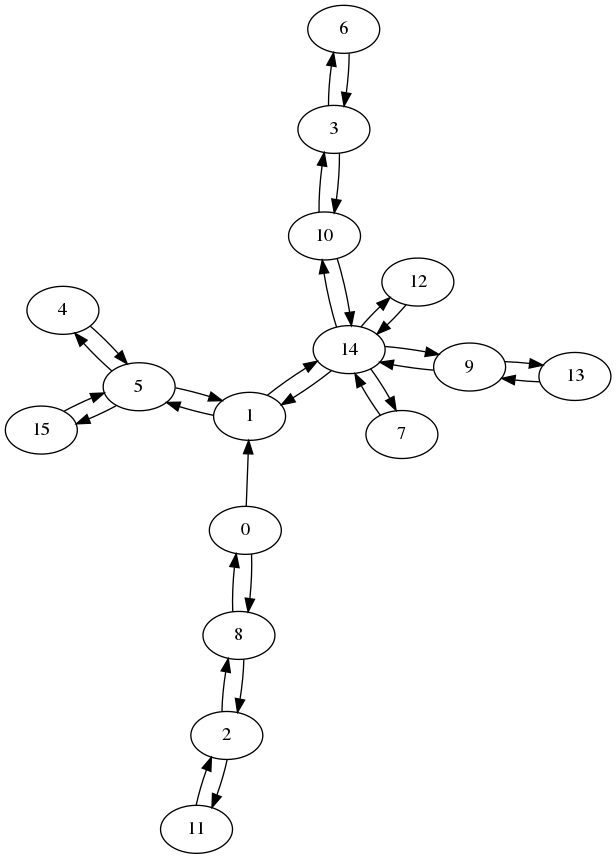

In [107]:
coupling_map = [[0,1], [1,2], [2,3], [3,4]]
cyclic_coupling_map = [[5, 6], [6, 7], [7,8], [8,6]]
random_connected_list = [[0, 1], [0, 8], [1, 5], [1, 14], [2, 8], [2, 11], 
                         [3, 6], [3, 10], [4, 5], [5, 1], [5, 4], [5, 15], 
                         [6, 3], [7, 14], [8, 0], [8, 2], [9, 13], [9, 14], 
                         [10, 3], [10, 14], [11, 2], [12, 14], [13, 9], 
                         [14, 1], [14, 7], [14, 9], [14, 10], [14, 12], [15, 5]]


coupling_map = CouplingMap(random_connected_list)
coupling_map.draw()

In [8]:
str(coupling_map)

'[[0, 1], [1, 2], [2, 3], [3, 4]]'

In [41]:
tree = ast.parse("[[0,1], [1,2], [2,3], [3,4]]")
astpretty.pprint(tree.body[0].value)

List(
    lineno=1,
    col_offset=0,
    end_lineno=1,
    end_col_offset=28,
    elts=[
        List(
            lineno=1,
            col_offset=1,
            end_lineno=1,
            end_col_offset=6,
            elts=[
                Constant(lineno=1, col_offset=2, end_lineno=1, end_col_offset=3, value=0, kind=None),
                Constant(lineno=1, col_offset=4, end_lineno=1, end_col_offset=5, value=1, kind=None),
            ],
            ctx=Load(),
        ),
        List(
            lineno=1,
            col_offset=8,
            end_lineno=1,
            end_col_offset=13,
            elts=[
                Constant(lineno=1, col_offset=9, end_lineno=1, end_col_offset=10, value=1, kind=None),
                Constant(lineno=1, col_offset=11, end_lineno=1, end_col_offset=12, value=2, kind=None),
            ],
            ctx=Load(),
        ),
        List(
            lineno=1,
            col_offset=15,
            end_lineno=1,
            end_col_offset=20,
    

In [36]:
show_tree("""
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=[[0,1], [1,2], [2,3], [3,4]])
qc.draw(fold=-1)""")

Module(
    body=[
        Assign(
            lineno=2,
            col_offset=0,
            end_lineno=2,
            end_col_offset=101,
            targets=[Name(lineno=2, col_offset=0, end_lineno=2, end_col_offset=2, id='qc', ctx=Store())],
            value=Call(
                lineno=2,
                col_offset=5,
                end_lineno=2,
                end_col_offset=101,
                func=Name(lineno=2, col_offset=5, end_lineno=2, end_col_offset=14, id='transpile', ctx=Load()),
                args=[Name(lineno=2, col_offset=15, end_lineno=2, end_col_offset=17, id='qc', ctx=Load())],
                keywords=[
                    keyword(
                        arg='basis_gates',
                        value=Constant(lineno=2, col_offset=31, end_lineno=2, end_col_offset=35, value=None, kind=None),
                    ),
                    keyword(
                        arg='optimization_level',
                        value=Constant(lineno=2, col_offset=56, e

In [33]:
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, execute
qc = QuantumCircuit(10, 10)
qc.h(0)
qc.cnot(0,1)
qc.cnot(1,2)
qc.cnot(2,3)
qc.cnot(3,4)
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
qc.measure(3, 3)
qc.measure(4, 4)
qc = transpile(qc, basis_gates=None, optimization_level=3, coupling_map=coupling_map)
qc.draw(fold=-1)

TranspilerError: 'Number of qubits (10) in circuit-421 is greater than maximum (5) in the coupling_map'

In [23]:
counts = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024, coupling_map=coupling_map).result().get_counts(qc)
counts

TranspilerError: 'Number of qubits (10) in circuit-395 is greater than maximum (5) in the coupling_map'

In [32]:
import scipy
n_nodes = 5
edge_density =.3
adjacency_matrix = scipy.sparse.random(
    n_nodes, n_nodes, density=edge_density, format='coo')
[list(a) for a in zip(adjacency_matrix.row, adjacency_matrix.col)]

[[0, 2], [2, 4], [1, 0], [0, 0], [0, 3], [1, 4], [2, 0], [1, 1]]

In [84]:
list(set([1,2,3]).difference(set([1,2])))

{3}

In [86]:
# create connected coupling map
n_nodes = 10
edge_density = .5
m = np.zeros((n_nodes, n_nodes), dtype=int)

# we remove n_nodes because we forbid the diagonal (self loops)
possible_edges = (n_nodes * n_nodes) - n_nodes

nodes_in_network = [0, 1]
m[0, 1] = 1
c_density = 1 / possible_edges

# force_connection 
nodes_out_of_network = list(
    set(list(range(n_nodes))).difference(set(nodes_in_network)))

while c_density < edge_density:
    outgoing_edge = np.random.choice([True, False])

    # master node
    master_node = np.random.choice(nodes_in_network)
    print(master_node)
    
    if outgoing_edge:
        direction_to_look_for = m[:,master_node]
    else:
        direction_to_look_for = m[master_node,:]
    
    if len(nodes_out_of_network) > 0:
        available_targets = nodes_out_of_network
    else:
        available_targets = list(np.argwhere(~np.array(direction_to_look_for, dtype=bool)).flatten())

    if master_node in available_targets:    
        # reason: to fobid self loops to be chosen
        available_targets.remove(master_node)
    if len(available_targets) > 0:
        print(f"available_targets: {available_targets}")
        target_node = int(np.random.choice(available_targets))
        print(f"target_node: {target_node}")
        if outgoing_edge:
            m[master_node][target_node] = 1
        else:
            m[target_node][master_node] = 1

    nodes_in_network.append(target_node)
    nodes_out_of_network = list(
        set(list(range(n_nodes))).difference(set(nodes_in_network)))
    
    print(m)
    c_edges = np.sum(m)

    c_density = float(c_edges) / possible_edges

adjacency_matrix = scipy.sparse.coo_matrix(m)
[list(a) for a in zip(adjacency_matrix.row, adjacency_matrix.col)]

1
available_targets: [2, 3, 4, 5, 6, 7, 8, 9]
target_node: 3
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
3
available_targets: [2, 4, 5, 6, 7, 8, 9]
target_node: 6
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
3
available_targets: [2, 4, 5, 7, 8, 9]
target_node: 7
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
3
available_targets: [2, 4, 5, 8, 9]
target_node: 2
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 

[[0, 1],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 9],
 [1, 2],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 9],
 [2, 0],
 [2, 3],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 9],
 [3, 0],
 [3, 1],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 9],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],
 [4, 5],
 [4, 7],
 [5, 2],
 [5, 8],
 [6, 4],
 [6, 5],
 [6, 7],
 [6, 8],
 [7, 5],
 [7, 8],
 [7, 9],
 [8, 0],
 [8, 1],
 [8, 3],
 [8, 4],
 [8, 9],
 [9, 4],
 [9, 5],
 [9, 6]]

In [56]:
~np.array(m[:,0], dtype=bool)

array([False,  True,  True,  True,  True])

In [57]:
 np.argwhere(~np.array(m[:,0], dtype=bool))

array([[1],
       [2],
       [3],
       [4]])

## How to use unitary

In [125]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)

_id = np.eye(2, 2)
_not = np.matrix([[0, 1], [1, 0]])
squs = [_id, _not, _id, _not]

qc.uc(squs, q[1:], q[0])
# Decompose the gate
qc = transpile(qc, basis_gates=["u1", "u3", "u2", "cx", "id"])
# Simulate the decomposed gate
simulator = Aer.get_backend("unitary_simulator")
result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)

last_statevector = unitary[-1]

print(last_statevector)
proabilities = np.real(np.multiply(last_statevector, np.conjugate(last_statevector)))

[0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 1.71008777e-17-1.00000000e+00j 8.51765664e-17+1.01465364e-17j]


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 7.35799967e-33])

## Manual Run

### SOURCE

In [205]:
# ID: qmt_v01 d51ec01569ed4b89a52aa79d7ba57331

In [198]:

# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(11, name='qr_qr')
cr_qr = ClassicalRegister(11, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
#qc.append(CCXGate(), qargs=[qr_qr[10], qr_qr[0], qr_qr[9]], cargs=[])
qc.append(RXXGate(1.214286075933729), qargs=[qr_qr[2], qr_qr[4]], cargs=[])
#qc.append(RZZGate(1.5279295607940084), qargs=[qr_qr[2], qr_qr[8]], cargs=[])
qc.append(SwapGate(), qargs=[qr_qr[4], qr_qr[0]], cargs=[])
#qc.append(SdgGate(), qargs=[qr_qr[6]], cargs=[])

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
qc.draw(fold=-1)

┌─┐   
 qr_qr_0: ───────────────────────X────────────────┤M├───
                          ┌─┐    │                └╥┘   
 qr_qr_1: ────────────────┤M├────┼─────────────────╫────
          ┌──────────────┐└╥┘    │             ┌─┐ ║    
 qr_qr_2: ┤0             ├─╫─────┼─────────────┤M├─╫────
          │              │ ║ ┌─┐ │             └╥┘ ║    
 qr_qr_3: ┤  Rxx(1.2143) ├─╫─┤M├─┼──────────────╫──╫────
          │              │ ║ └╥┘ │              ║  ║ ┌─┐
 qr_qr_4: ┤1             ├─╫──╫──X──────────────╫──╫─┤M├
          └─────┬─┬──────┘ ║  ║                 ║  ║ └╥┘
 qr_qr_5: ──────┤M├────────╫──╫─────────────────╫──╫──╫─
                └╥┘        ║  ║ ┌─┐             ║  ║  ║ 
 qr_qr_6: ───────╫─────────╫──╫─┤M├─────────────╫──╫──╫─
                 ║         ║  ║ └╥┘┌─┐          ║  ║  ║ 
 qr_qr_7: ───────╫─────────╫──╫──╫─┤M├──────────╫──╫──╫─
                 ║         ║  ║  ║ └╥┘┌─┐       ║  ║  ║ 
 qr_qr_8: ───────╫─────────╫──╫──╫──╫─┤M├───────╫──╫──╫─
                 ║         ║  ║  ║  ║ └╥┘┌─┐    ║  ║  ║ 
 qr_qr_9: ───────╫─────────╫──╫──╫──╫──╫─┤M├────╫──╫──╫─
                 ║         ║  ║  ║  ║  ║ └╥┘┌─┐ ║  ║  ║ 
qr_qr_10: ───────╫─────────╫──╫──╫──╫──╫──╫─┤M├─╫──╫──╫─
                 ║         ║  ║  ║  ║  ║  ║ └╥┘ ║  ║  ║ 
cr_qr: 11/═══════╩═════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                 5         1  3  6  7  8  9  10 2  0  4

In [199]:


# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_6b172cc212eb423a8286969be00ac37f = Aer.get_backend('qasm_simulator')
counts_source = execute(qc, backend=backend_6b172cc212eb423a8286969be00ac37f, shots=7838).result().get_counts(qc)
counts_source

{'00000000101': 2591, '00000000000': 5247}

### FOLLOW

In [200]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(11, name='qr_qr')
cr_qr = ClassicalRegister(11, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
#qc.append(CCXGate(), qargs=[qr_qr[10], qr_qr[0], qr_qr[9]], cargs=[])
qc.append(RXXGate(1.214286075933729), qargs=[qr_qr[2], qr_qr[4]], cargs=[])
#qc.append(RZZGate(1.5279295607940084), qargs=[qr_qr[2], qr_qr[8]], cargs=[])
qc.append(SwapGate(), qargs=[qr_qr[4], qr_qr[0]], cargs=[])
#qc.append(SdgGate(), qargs=[qr_qr[6]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=3)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
qc.draw(fold=-1)

┌─┐                           
 qr_qr_0: ────────────────┤M├───────────────────────────
                          └╥┘┌─┐                        
 qr_qr_1: ─────────────────╫─┤M├────────────────────────
          ┌──────────────┐ ║ └╥┘                  ┌─┐   
 qr_qr_2: ┤0             ├─╫──╫───────────────────┤M├───
          │              │ ║  ║ ┌─┐               └╥┘   
 qr_qr_3: ┤  Rxx(1.2143) ├─╫──╫─┤M├────────────────╫────
          │              │ ║  ║ └╥┘                ║ ┌─┐
 qr_qr_4: ┤1             ├─╫──╫──╫─────────────────╫─┤M├
          └─────┬─┬──────┘ ║  ║  ║                 ║ └╥┘
 qr_qr_5: ──────┤M├────────╫──╫──╫─────────────────╫──╫─
                └╥┘        ║  ║  ║ ┌─┐             ║  ║ 
 qr_qr_6: ───────╫─────────╫──╫──╫─┤M├─────────────╫──╫─
                 ║         ║  ║  ║ └╥┘┌─┐          ║  ║ 
 qr_qr_7: ───────╫─────────╫──╫──╫──╫─┤M├──────────╫──╫─
                 ║         ║  ║  ║  ║ └╥┘┌─┐       ║  ║ 
 qr_qr_8: ───────╫─────────╫──╫──╫──╫──╫─┤M├───────╫──╫─
                 ║         ║  ║  ║  ║  ║ └╥┘┌─┐    ║  ║ 
 qr_qr_9: ───────╫─────────╫──╫──╫──╫──╫──╫─┤M├────╫──╫─
                 ║         ║  ║  ║  ║  ║  ║ └╥┘┌─┐ ║  ║ 
qr_qr_10: ───────╫─────────╫──╫──╫──╫──╫──╫──╫─┤M├─╫──╫─
                 ║         ║  ║  ║  ║  ║  ║  ║ └╥┘ ║  ║ 
cr_qr: 11/═══════╩═════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                 5         0  1  3  6  7  8  9  10 2  4

In [201]:

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_6b172cc212eb423a8286969be00ac37f = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_6b172cc212eb423a8286969be00ac37f, shots=7838).result().get_counts(qc)
counts_follow


{'00000000000': 5319, '00000010100': 2519}

In [202]:
counts_follow
{k: v for k, v in sorted(counts_follow.items(), key=lambda item: item[1])}

{'00000010100': 2519, '00000000000': 5319}

In [203]:
counts_source
{k: v for k, v in sorted(counts_source.items(), key=lambda item: item[1])}

{'00000000101': 2591, '00000000000': 5247}

In [ ]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(3, name='qr_qr')
cr_qr = ClassicalRegister(3, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(RCCXGate(), qargs=[qr_qr[1], qr_qr[0], qr_qr[2]], cargs=[])
qc.append(TGate(), qargs=[qr_qr[2]], cargs=[])
qc.append(IGate(), qargs=[qr_qr[0]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[1]], cargs=[])
qc.append(TGate(), qargs=[qr_qr[2]], cargs=[])
qc.append(UGate(0.9807528981981786, 2.567185003403143, 1.2508606990611186), qargs=[qr_qr[0]], cargs=[])
qc.append(CSwapGate(), qargs=[qr_qr[0], qr_qr[2], qr_qr[1]], cargs=[])
qc.append(RCCXGate(), qargs=[qr_qr[1], qr_qr[0], qr_qr[2]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[1], qr_qr[0]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[1]], cargs=[])
qc.append(RYYGate(4.3059217797542395), qargs=[qr_qr[0], qr_qr[2]], cargs=[])
qc.append(RXGate(1.385141564493705), qargs=[qr_qr[1]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[0], qr_qr[1]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[0], qr_qr[2]], cargs=[])
qc.append(RCCXGate(), qargs=[qr_qr[2], qr_qr[0], qr_qr[1]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[0], qr_qr[2]], cargs=[])
qc.append(SGate(), qargs=[qr_qr[2]], cargs=[])
qc.append(UGate(0.11393195140691285, 4.68908149414998, 0.18104047437188872), qargs=[qr_qr[0]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=1)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_fccdde1d54a445c0a68091c036637e3c = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_fccdde1d54a445c0a68091c036637e3c, shots=489).result().get_counts(qc)
RESULT = counts

# READ SOURCE CODE

In [4]:
PROGRAM_ID = "410155813be54a5287994c1d80c992dd"
PATH_SOURCE = os.path.join(config["experiment_folder"], "programs", "source", f"{PROGRAM_ID}.py")
print(open(PATH_SOURCE, 'r').read())
print("-" * 80)
PATH_FOLLOWUP = os.path.join(config["experiment_folder"], "programs", "followup", f"{PROGRAM_ID}.py")
print(open(PATH_FOLLOWUP, 'r').read())


# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *

# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(9, name='qr_qr')
cr_qr = ClassicalRegister(9, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(SXdgGate(), qargs=[qr_qr[7]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[6]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[4]], cargs=[])

# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)

# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)

# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_213141889afb4ac19d274fe469f89af0 = Aer.get_backend('qasm_simulator')


# MINIMIZATION - CUDA NON-DETERMINISTIC BUG

In [ ]:
# qmt_v01 PROGRAM ID: 410155813be54a5287994c1d80c992dd

In [ ]:
# AER: densitymatrix_thrust.hpp
# https://github.com/Qiskit/qiskit-aer/blob/53038b1962894469fcadbcd435e4f31468886f6c/src/simulators/density_matrix/densitymatrix_thrust.hpp
    
# CUDA THRUST (CUDA C++ template library): thrust/system/cuda/detail/for_each.h
# https://github.com/NVIDIA/thrust/blob/a462ff612acfb099e78e35b57644612370969fb0/thrust/system/cuda/detail/for_each.h

# OFFICIAL DOC of CUDA C++ template library: https://docs.nvidia.com/cuda/thrust/index.html


In [10]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(9, name='qr_qr')
cr_qr = ClassicalRegister(9, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(SXdgGate(), qargs=[qr_qr[7]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[6]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[4]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
# SECTION
# NAME: EXECUTION
from qiskit import Aer, transpile, execute
backend_213141889afb4ac19d274fe469f89af0 = Aer.get_backend(
    'aer_simulator_density_matrix_gpu')
counts = execute(qc, backend=backend_213141889afb4ac19d274fe469f89af0,
    shots=3919).result().get_counts(qc)
RESULT = counts

In [11]:
counts

{'000000100': 995, '010000100': 984, '001000100': 1002, '011000100': 938}

In [ ]:
# New program couple... [timer: 120 sec]
# Follow: replace backend qasm_simulator -> aer_simulator_density_matrix_gpu
# Executing: 410155813be54a5287994c1d80c992dd
# terminate called after throwing an instance of 'thrust::system::system_error'
#   what():  for_each: failed to synchronize: cudaErrorInitializationError: initialization error

In [5]:
program = """# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(9, name='qr_qr')
cr_qr = ClassicalRegister(9, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(SXdgGate(), qargs=[qr_qr[7]], cargs=[])
qc.append(ECRGate(), qargs=[qr_qr[2], qr_qr[6]], cargs=[])
qc.append(iSwapGate(), qargs=[qr_qr[5], qr_qr[4]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
# SECTION
# NAME: OPTIMIZATION_LEVEL

from qiskit import transpile
qc = transpile(qc, basis_gates=None, optimization_level=0)
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
# SECTION
# NAME: EXECUTION
from qiskit import Aer, transpile, execute
backend_213141889afb4ac19d274fe469f89af0 = Aer.get_backend(
    'aer_simulator_density_matrix_gpu')
counts = execute(qc, backend=backend_213141889afb4ac19d274fe469f89af0,
    shots=3919).result().get_counts(qc)
RESULT = counts
"""

GLOBALS = {"RESULT": 0}
exec(program, GLOBALS)
GLOBALS["RESULT"]

{'011000100': 976, '010000100': 991, '000000100': 990, '001000100': 962}

# MINIMIZATION - SWAP

### SOURCE

In [205]:
# ID: qmt_v01 d51ec01569ed4b89a52aa79d7ba57331

In [387]:
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.circuit.library.standard_gates import *
qc = QuantumCircuit(3)
qc.x(0)
qc.swap(0,1)
qc = transpile(qc, optimization_level=0)
qc.measure_all()
qc.draw(fold=-1)

┌───┐    ░ ┌─┐      
   q_0: ┤ X ├─X──░─┤M├──────
        └───┘ │  ░ └╥┘┌─┐   
   q_1: ──────X──░──╫─┤M├───
                 ░  ║ └╥┘┌─┐
   q_2: ─────────░──╫──╫─┤M├
                 ░  ║  ║ └╥┘
meas: 3/════════════╩══╩══╩═
                    0  1  2

In [388]:
counts = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
counts

{'010': 1024}

### FOLLOW

In [389]:
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.circuit.library.standard_gates import *
qc = QuantumCircuit(3)
qc.x(0)
qc.swap(0,1)
import pdb
pdb.set_trace()
qc = transpile(qc, optimization_level=3)
qc.measure_all()
qc.draw(fold=-1)

--Return--
None
> /tmp/ipykernel_48930/3381773960.py(7)<module>()
      5 qc.swap(0,1)
      6 import pdb
----> 7 pdb.set_trace()
      8 qc = transpile(qc, optimization_level=3)
      9 qc.measure_all()

ipdb> c


┌───┐ ░ ┌─┐      
   q_0: ┤ X ├─░─┤M├──────
        └───┘ ░ └╥┘┌─┐   
   q_1: ──────░──╫─┤M├───
              ░  ║ └╥┘┌─┐
   q_2: ──────░──╫──╫─┤M├
              ░  ║  ║ └╥┘
meas: 3/═════════╩══╩══╩═
                 0  1  2

In [ ]:
# dag_to_circuit(dag).draw(fold=-1)

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passmanager.py:218
# run()

# self.working_list
[<qiskit.transpiler.runningpassmanager.FlowControllerLinear object at 0x7fb92b015850>, 
 <qiskit.transpiler.runningpassmanager.FlowControllerLinear object at 0x7fb92b015940>, 
 <qiskit.transpiler.runningpassmanager.FlowControllerLinear object at 0x7fb92b0159a0>, 
 <qiskit.transpiler.runningpassmanager.FlowControllerLinear object at 0x7fb92b015c70>, 
 <qiskit.transpiler.runningpassmanager.DoWhileController object at 0x7fb92b015ca0>, 
 <qiskit.transpiler.runningpassmanager.FlowControllerLinear object at 0x7fb92b0151f0>, 
 <qiskit.transpiler.runningpassmanager.ConditionalController object at 0x7fb92b015550>, 
 <qiskit.transpiler.runningpassmanager.FlowControllerLinear object at 0x7fb92b015b50>]

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:123
# run()

qiskit.transpiler.passes.optimization.optimize_swap_before_measure.OptimizeSwapBeforeMeasure

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/optimize_swap_before_measure.py:29
# run()

# b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/optimize_swap_before_measure.py:44

In [390]:
counts = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
counts

{'001': 1024}

In [370]:
counts_follow
{k: v for k, v in sorted(counts_follow.items(), key=lambda item: item[1])}

{'100': 7838}

In [371]:
counts_source
{k: v for k, v in sorted(counts_source.items(), key=lambda item: item[1])}

{'001': 7838}

# MINIMIZATION - ID with CHANGE OF BASIS

### SOURCE

In [312]:
# ID: qmt_v01 6e8363d301e44b0c833f51d6918af826

In [362]:
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, execute
qc = QuantumCircuit(1)
qc.id(0)
qc.measure_all()
qc = transpile(qc, basis_gates=None, optimization_level=0)
qc.draw(fold=-1)
counts = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=1024).result().get_counts(qc)
counts

{'0': 1024}

{'0': 489}

### FOLLOW

In [359]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import transpile
qc = QuantumCircuit(1)
qc.id(0)
qc.measure_all()
qc = transpile(qc, basis_gates=['rx', 'ry', 'rz', 'p', 'cx'], optimization_level=0)
qc.draw(fold=-1)

QiskitError: "Cannot unroll the circuit to the given basis, ['rx', 'ry', 'rz', 'p', 'cx']. Instruction id not found in equivalence library and no rule found to expand."

In [349]:

# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_d3ff37282d7e43d19cf389b7e5b42747 = Aer.get_backend('qasm_simulator')
counts_follow = execute(qc, backend=backend_d3ff37282d7e43d19cf389b7e5b42747, shots=489).result().get_counts(qc)
counts_follow


{'000': 489}

### COMPARE

In [341]:
counts_follow
{k: v for k, v in sorted(counts_follow.items(), key=lambda item: item[1])}

{'010': 14,
 '011': 17,
 '000': 21,
 '001': 47,
 '101': 55,
 '111': 95,
 '100': 104,
 '110': 136}

In [342]:
counts_source
{k: v for k, v in sorted(counts_source.items(), key=lambda item: item[1])}

{'011': 8,
 '010': 8,
 '000': 22,
 '001': 37,
 '101': 58,
 '111': 104,
 '100': 118,
 '110': 134}

In [343]:
from inspector import OneNightStandInspector
from detectors import KS_Detector, Energy_Detector

In [346]:
detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")

stat: 0.049079754601226995, pval: 0.5984096532139881


n_qubits: 3
n_shots: 489.0
Uniform threshold: 61.125


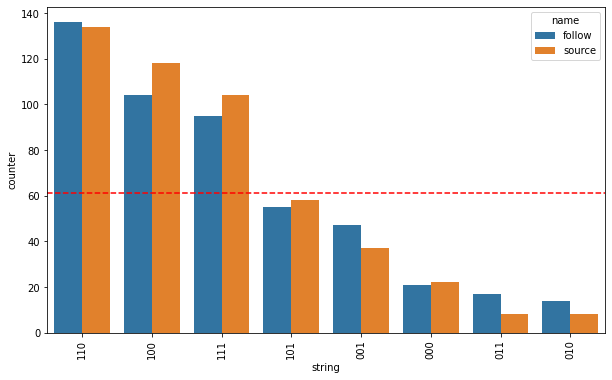

In [347]:
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)

# FALSE ALARMS

In [236]:
# ID: qmt_v01 771e36d9d8de4524ba3c14e71f984a46

#SOURCE
{'001': 4,
 '011': 18,
 '111': 22,
 '101': 23,
 '000': 53,
 '110': 99,
 '100': 121,
 '010': 149}

#FOLLOW
{'001': 3,
 '011': 19,
 '101': 31,
 '111': 36,
 '000': 43,
 '110': 97,
 '100': 103,
 '010': 157}

""

''

stat: 0.015878744135691087, pval: 0.8760028027498028
n_qubits: 8
n_shots: 2771.0
Uniform threshold: 10.82421875


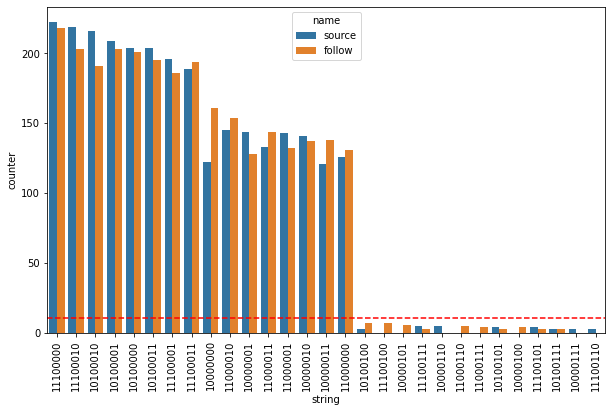

In [327]:
# ID: qmt_v01 7626fc0fb4044fc89a3b8fc6c2b243fa

counts_source = {'11000100': 1,
 '11000111': 1,
 '10100110': 1,
 '10000100': 2,
 '11000110': 2,
 '10100100': 3,
 '10000111': 3,
 '10100111': 3,
 '11100110': 3,
 '11100101': 4,
 '10100101': 4,
 '11100111': 5,
 '10000110': 5,
 '10000011': 121,
 '10000000': 122,
 '11000000': 126,
 '11000011': 133,
 '10000010': 141,
 '11000001': 143,
 '10000001': 144,
 '11000010': 145,
 '11100011': 189,
 '11100001': 196,
 '10100011': 204,
 '10100000': 204,
 '10100001': 209,
 '10100010': 216,
 '11100010': 219,
 '11100000': 222}

counts_follow = {'11000101': 1,
 '10100110': 1,
 '10000111': 2,
 '11100110': 2,
 '10000110': 2,
 '11000100': 2,
 '11100111': 3,
 '10100111': 3,
 '11100101': 3,
 '10100101': 3,
 '10000100': 4,
 '11000111': 4,
 '11000110': 5,
 '10000101': 6,
 '11100100': 7,
 '10100100': 7,
 '10000001': 128,
 '11000000': 131,
 '11000001': 132,
 '10000010': 137,
 '10000011': 138,
 '11000011': 144,
 '11000010': 154,
 '10000000': 161,
 '11100001': 186,
 '10100010': 191,
 '11100011': 194,
 '10100011': 195,
 '10100000': 201,
 '11100010': 203,
 '10100001': 203,
 '11100000': 218}

from inspector import OneNightStandInspector
from detectors import KS_Detector, Energy_Detector

detector = KS_Detector()
stat, pval = detector.check(counts_source, counts_follow)
print(f"stat: {stat}, pval: {pval}")
OneNightStandInspector(counts_source, counts_follow, name_a="source", name_b="follow", top_perc=1)

## FOLLOW (BASIC GATES)

In [151]:
# SECTION
# NAME: PROLOGUE

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import *
# SECTION
# NAME: CIRCUIT

qr_qr = QuantumRegister(5, name='qr_qr')
cr_qr = ClassicalRegister(5, name='cr_qr')
qc = QuantumCircuit(qr_qr, cr_qr, name='qc')
qc.append(CZGate(), qargs=[qr_qr[0], qr_qr[1]], cargs=[])
qc.append(HGate(), qargs=[qr_qr[4]], cargs=[])
qc.append(CUGate(0.8743215461586589, 3.6461526174144714, 1.0457574994884162, 1.1064426019797104), qargs=[qr_qr[3], qr_qr[4]], cargs=[])
qc.append(PhaseGate(4.14990597292941), qargs=[qr_qr[3]], cargs=[])
qc.append(CXGate(), qargs=[qr_qr[2], qr_qr[4]], cargs=[])
qc.append(C3XGate(3.685827592928898), qargs=[qr_qr[0], qr_qr[4], qr_qr[2], qr_qr[1]], cargs=[])
qc.append(C3XGate(4.616110935538422), qargs=[qr_qr[1], qr_qr[0], qr_qr[4], qr_qr[2]], cargs=[])
qc.append(CUGate(3.808150863427504, 3.853799014455113, 3.9815403169823433, 5.631402019842159), qargs=[qr_qr[4], qr_qr[3]], cargs=[])
qc.append(SXGate(), qargs=[qr_qr[0]], cargs=[])
qc.append(PhaseGate(0.8029501314368291), qargs=[qr_qr[0]], cargs=[])
qc.append(CCXGate(), qargs=[qr_qr[0], qr_qr[3], qr_qr[2]], cargs=[])
qc.append(CSXGate(), qargs=[qr_qr[4], qr_qr[3]], cargs=[])
# SECTION
# NAME: OPTIMIZATION_PASSES

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import *
passmanager = PassManager()
qc = passmanager.run(qc)
qc.draw(fold=-1)

┌────┐              ┌────────────┐           
qr_qr_0: ──■─────────────────────────────────────────────────────────■─────■─────────────────┤ √X ├──────────────┤ P(0.80295) ├──■────────
           │                                                       ┌─┴──┐  │                 └────┘              └────────────┘  │        
qr_qr_1: ──■───────────────────────────────────────────────────────┤ Sx ├──■─────────────────────────────────────────────────────┼────────
                                                                   └─┬──┘┌─┴──┐                                                ┌─┴─┐      
qr_qr_2: ───────────────────────────────────────────────────────■────■───┤ Sx ├────────────────────────────────────────────────┤ X ├──────
                                                 ┌───────────┐  │    │   └─┬──┘┌────────────────────────────────┐              └─┬─┘┌────┐
qr_qr_3: ──────────────────────■─────────────────┤ P(4.1499) ├──┼────┼─────┼───┤ U(3.8082,3.8538,3.9815,5.6314) ├────────────────■──┤ Sx ├
         ┌───┐┌────────────────┴────────────────┐└───────────┘┌─┴─┐  │     │   └───────────────┬────────────────┘                   └─┬──┘
qr_qr_4: ┤ H ├┤ U(0.87432,3.6462,1.0458,1.1064) ├─────────────┤ X ├──■─────■───────────────────■──────────────────────────────────────■───
         └───┘└─────────────────────────────────┘             └───┘                                                                       
cr_qr: 5/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [148]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [150]:
# SECTION
# NAME: OPTIMIZATION_LEVEL
from qiskit import transpilec
import pdb
pdb.set_trace()
qc = transpile(qc, basis_gates=['cx', 'h', 's', 't'], optimization_level=2)

--Return--
None
> /tmp/ipykernel_48930/3525238346.py(5)<module>()
      2 # NAME: OPTIMIZATION_LEVEL
      3 from qiskit import transpile
      4 import pdb
----> 5 pdb.set_trace()
      6 qc = transpile(qc, basis_gates=['cx', 'h', 's', 't'], optimization_level=2)

ipdb> b /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py:367
Breakpoint 1 at /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py:367
ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> logger..setLevel(logging.DEBUG)
*** SyntaxError: invalid syntax
ipdb> logger.setLevel(logging.DEBUG)
ipdb> c
> /h

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)


ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> 
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
 

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)
    369         closed_set.add(current_basis)

ipdb> c
> /home/paltenmo/.conda/envs/ML4Quantum/lib/python3.8/site-packages/qiskit/transpiler/passes/basis/basis_translator.py(367)_basis_search()
    365             return rtn
    366 
1-> 367         logger.debug("Inspecting basis %s.", current_basis)
    368         open_set.remove(current_basis)


BdbQuit: 

In [146]:
# SECTION
# NAME: MEASUREMENT

qc.measure(qr_qr, cr_qr)
# SECTION
# NAME: EXECUTION

from qiskit import Aer, transpile, execute
backend_d20de290415b4d84810e4a91b288727a = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=backend_d20de290415b4d84810e4a91b288727a, shots=979).result().get_counts(qc)
RESULT = counts

KeyboardInterrupt: 